In [1]:
import os
import pandas as pd
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import csv


Bad key text.latex.preview in file C:\Users\Dan\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\Dan\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\Dan\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the de

In [2]:
home_path = '../Resources/Zillow extra/Zip_Code_SFR-ONLY_month.csv'
irs_path = '../Resources/Income/IRS_income_2019.csv'

In [15]:
# Data cleaning
df = pd.read_csv(irs_path)
irs = df[['zipcode', 'N1', 'A00100']]
irs.columns=['zip', 'returns', 'AGI']
irs2 = irs.set_index(['zip'])
irs2.tail()

returns       AGI
zip                     
99999   3370.0  122741.0
99999   2340.0  144810.0
99999   1740.0  151288.0
99999   2740.0  367993.0
99999    850.0  552036.0

In [17]:
# Step 1: Calculate the average income for each tax bracket in each zip code
irs2['Average_Income'] = (irs2['AGI'] * 1000) / irs2['returns']
# Step 2: Group by 'zip' and calculate the mean of 'Average_Income' for each zip code
average_income_by_zip = irs2.groupby(irs2.index)['Average_Income'].mean()

In [21]:
irs3 = pd.DataFrame(average_income_by_zip)

In [29]:
irs3.tail()

Average_Income
zip                  
99827   166373.385446
99833   109327.731492
99835   127659.590320
99901   122601.254122
99999   161986.138886

In [30]:
irs3.to_csv('test_irs.csv', index=True)
# irs2 = irs2.drop(columns=['returns', 'AGI'])

In [31]:
irs3.columns = ['Avg_AGI']

In [33]:
# Data cleaning
df1 = pd.read_csv(home_path)
df1 = df1.drop(['SizeRank',
                'RegionType',
                'StateName',
                'State',
                'Metro',
                'City',
                'RegionName'
               ],
               axis=1)
df1.columns = [
    pd.to_datetime(col[0]) if isinstance(col, tuple) else col
    for col in df1.columns
]

In [34]:
# For export to Tableau
# Define the date range for columns you want to drop
start1 = '2000-02-29'
end1 = '2007-02-28'
# Find the indices of the columns to drop
drop_columns_indices = [
    idx for idx, col in enumerate(df1.columns)
    if start1 <= col <= end1
]
pre_GFC = df1.drop(df1.columns[drop_columns_indices], axis=1)

# Drop rest of the date range post-GFC
start2 = '2007-03-31'
# Find the index of the starting date column
idx = pre_GFC.columns.get_loc(start2)

columns_to_drop = pre_GFC.columns[idx + 1:]

pre_GFC = pre_GFC.drop(columns_to_drop, axis=1)
pre_GFC = pre_GFC.dropna()
pre_GFC.tail()

RegionID     CountyName     2000-01-31     2007-03-31
26890     98183  Sonoma County  118508.186735  283939.506842
26893     58818   Dukes County  392721.865099  746479.927482
26898     90369  Ottawa County   21936.560162   20105.170359
26899     63527   Yates County  103568.878459  141512.080140
26901     72882    Polk County   34751.096484   45480.387000

In [35]:
pre_GFC = pre_GFC.drop(['CountyName'], axis=1)

In [36]:
pre_GFC.columns = ['zip', '2000-01-31', '2007-03-31']
pre_GFC = pre_GFC.set_index(['zip'])
pre_GFC.head()

2000-01-31     2007-03-31
zip                                
61148  156166.648241  366745.179518
91982  224557.001178  258284.848768
91940  113835.082445  138063.865921
62080  285370.205204  607515.274708
92593  186790.375730  204506.131866

In [37]:
# Calculate percent gain and create a new 'Percent Gain' column
pre_GFC['Percent Gain'] = (pre_GFC['2007-03-31'] / pre_GFC['2000-01-31'] - 1) * 100
pre_GFC.tail()

2000-01-31     2007-03-31  Percent Gain
zip                                              
98183  118508.186735  283939.506842    139.594845
58818  392721.865099  746479.927482     90.078525
90369   21936.560162   20105.170359     -8.348573
63527  103568.878459  141512.080140     36.635717
72882   34751.096484   45480.387000     30.874682

In [38]:
pre_GFC = pre_GFC.drop(columns=['2000-01-31', '2007-03-31'])

In [39]:
pre_GFC_IRS = pd.merge(pre_GFC, irs3, on='zip', how='inner')
pre_GFC_IRS = pre_GFC_IRS.dropna()

In [40]:
# Calculate the lower and upper quantile values
q_low = pre_GFC_IRS.quantile(0.05)
q_high = pre_GFC_IRS.quantile(0.95)
# Filter out the outliers
pre_GFC_IRS = pre_GFC_IRS[(pre_GFC_IRS >= q_low) & (pre_GFC_IRS <= q_high)]
pre_GFC_IRS.head()

Percent Gain        Avg_AGI
zip                               
62080    112.886722   67501.655983
62019    132.425494   70996.666667
91733     21.726939  118467.408339
84630    112.030913   65311.111111
62037    148.299808  111061.646825

In [41]:
pre_GFC_IRS = pre_GFC_IRS.drop(index=pre_GFC_IRS[pre_GFC_IRS['Avg_AGI'] == 0].index)
pre_GFC_IRS.to_csv('test_irs.csv', index=True)

In [42]:
pre_GFC_IRS = pre_GFC_IRS.dropna()
pre_GFC_IRS.isnull().sum()

Percent Gain    0
Avg_AGI         0
dtype: int64

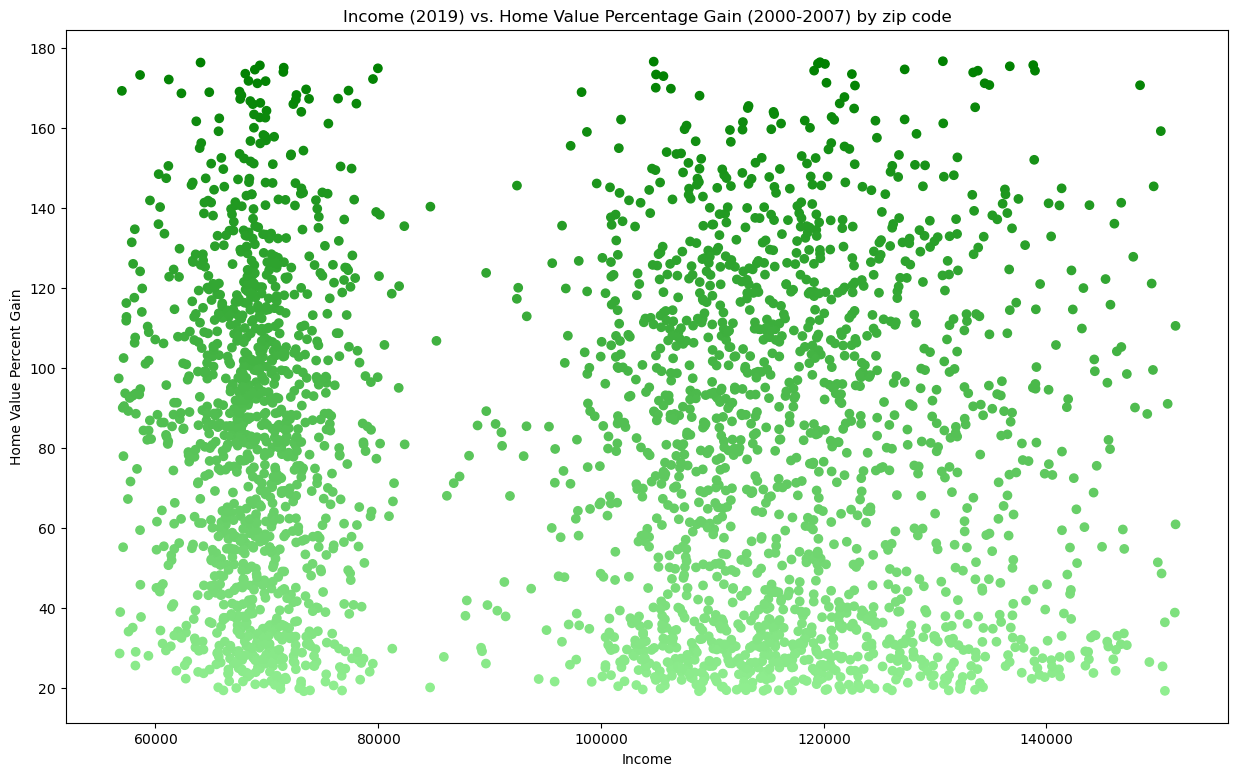

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
plt.figure(figsize=(15, 9))

colors = [(0, 'lightgreen'), (1, 'green')] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomColormap', colors)
plt.scatter(pre_GFC_IRS['Avg_AGI'], pre_GFC_IRS['Percent Gain'], c=pre_GFC_IRS['Percent Gain'], cmap=custom_cmap)

# Set the x-axis tick formatter to display the true units
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)

# Set other plot settings (labels, title, etc.)
plt.xlabel('Income')
plt.ylabel('Home Value Percent Gain')
plt.title('Income (2019) vs. Home Value Percentage Gain (2000-2007) by zip code')

# Show the plot
plt.show()

In [44]:
# Transpose while setting index to Date (this DF is for python, the rest are for export to Tableau)
# dfp = df1.rename(columns={'RegionID' : 'Date'})
# dfp = dfp.drop(['CountyName'], axis=1)
# dft = dfp.set_index('Date').T
# dft.head()

In [45]:
# Define the date range for columns you want to drop
start3 = '2007-04-30'
end3 = '2012-02-29'
# Find the indices of the columns to drop
drop_columns_indices3 = [
    idx for idx, col in enumerate(df1.columns)
    if start3 <= col <= end3
]
GFC = df1.drop(df1.columns[drop_columns_indices3], axis=1)
# Drop everything after the date range
start4 = '2012-03-31'
# Find the index of the starting date column
idx3 = GFC.columns.get_loc(start4)
# Drop columns from index to end
columns_to_drop3 = GFC.columns[idx3 + 1:]
GFC = GFC.drop(columns_to_drop3, axis=1)
# Drop everything before the date range
end4 = '2007-03-31'
idx4 = GFC.columns.get_loc(end4)
columns_to_drop4 = GFC.columns[2:idx4]
GFC = GFC.drop(columns_to_drop4, axis=1)

GFC = GFC.dropna()
GFC.tail()

RegionID     CountyName     2007-03-31     2012-03-31
26890     98183  Sonoma County  283939.506842  177527.646206
26893     58818   Dukes County  746479.927482  685947.633152
26898     90369  Ottawa County   20105.170359   25968.752014
26899     63527   Yates County  141512.080140  123168.714682
26901     72882    Polk County   45480.387000   25702.417899

In [46]:
# Calculate percent gain and create a new 'Percent Gain' column
GFC['Percent Gain'] = (GFC['2012-03-31'] / GFC['2007-03-31'] - 1) * 100

In [84]:
GFC.to_csv('tableau_GFC.csv', index=False)

In [48]:
GFC = GFC.drop(columns=['CountyName', '2007-03-31', '2012-03-31'], axis=1)
GFC.columns = ['zip', 'Percent Gain']

In [49]:
GFC = GFC.set_index(['zip'])
GFC_IRS = pd.merge(GFC, irs3, on='zip', how='inner')
GFC_IRS = GFC_IRS.dropna()
GFC_IRS.isnull().sum()
GFC_IRS.head()

Percent Gain        Avg_AGI
zip                               
62080    -25.037689   67501.655983
62019    -29.540267   70996.666667
91733     -9.968617  118467.408339
84630    -53.503588   65311.111111
62037    -16.041056  111061.646825

In [50]:
# Calculate the lower and upper quantile values
gfcq_low = GFC_IRS.quantile(0.05)
gfcq_high = GFC_IRS.quantile(0.95)
# Filter out the outliers
GFC_IRS = GFC_IRS[(GFC_IRS >= gfcq_low) & (GFC_IRS <= gfcq_high)]

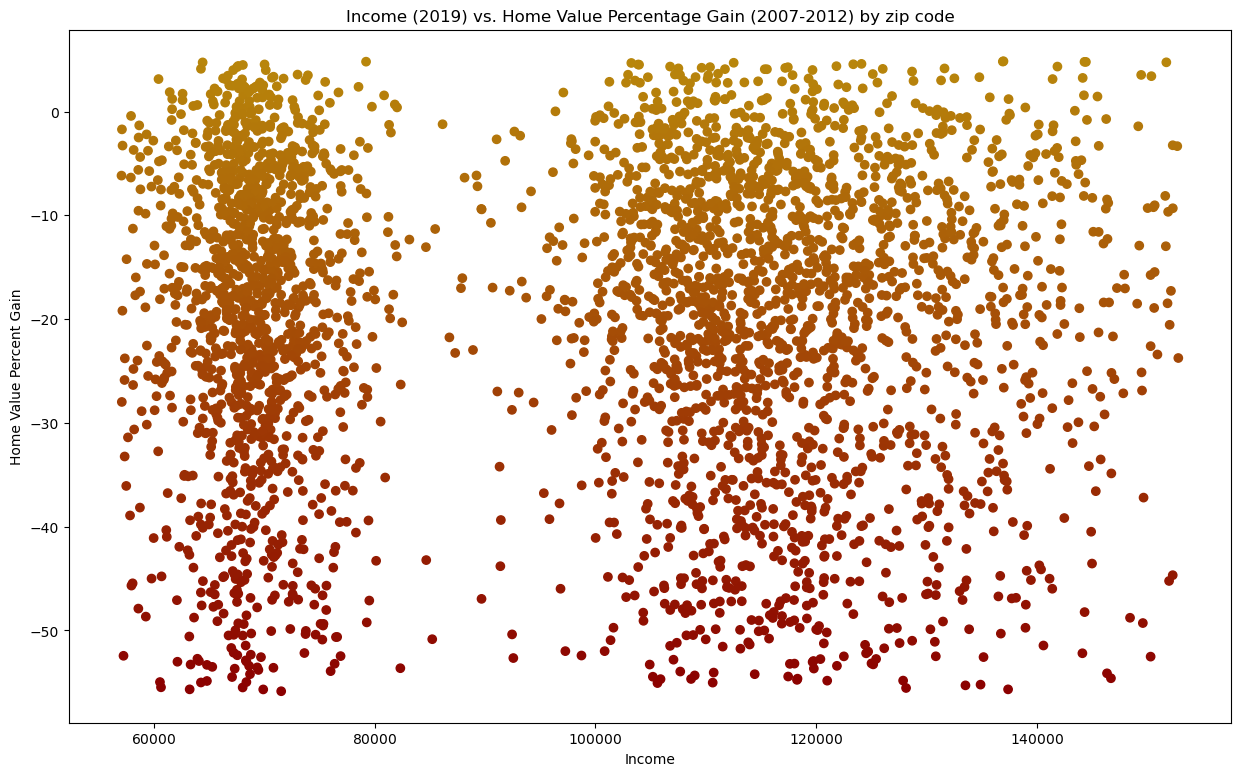

In [98]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
plt.figure(figsize=(15, 9))

colors = [(0, 'darkred'), (1, 'darkgoldenrod')] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomColormap', colors)
plt.scatter(GFC_IRS['Avg_AGI'], GFC_IRS['Percent Gain'], c=GFC_IRS['Percent Gain'], cmap=custom_cmap)

# Set the x-axis tick formatter to display the true units
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)

# Set other plot settings (labels, title, etc.)
plt.xlabel('Income')
plt.ylabel('Home Value Percent Gain')
plt.title('Income (2019) vs. Home Value Percentage Gain (2007-2012) by zip code')

# Show the plot
plt.show()

In [57]:
# Define the date range for columns you want to drop
start5 = '2012-04-30'
end5 = '2022-05-31'
# Find the indices of the columns to drop
drop_columns_indices5 = [
    idx for idx, col in enumerate(df1.columns)
    if start5 <= col <= end5
]
QE = df1.drop(df1.columns[drop_columns_indices5], axis=1)
# Drop everything after the date range
start6 = '2022-06-30'
# Find the index of the starting date column
idx5 = QE.columns.get_loc(start6)
# Drop columns from index to end
columns_to_drop5 = QE.columns[idx5 + 1:]
QE = QE.drop(columns_to_drop5, axis=1)

# Drop everything before the date range
end6 = '2012-03-31'
idx6 = QE.columns.get_loc(end6)
columns_to_drop6 = QE.columns[2:idx6]
QE = QE.drop(columns_to_drop6, axis=1)

QE = QE.dropna()
QE.tail()

RegionID      CountyName     2012-03-31     2022-06-30
26894     67368  Madison County  203030.421091  350191.814433
26898     90369   Ottawa County   25968.752014   51097.273958
26899     63527    Yates County  123168.714682  209623.766127
26901     72882     Polk County   25702.417899  117425.377194
26902     78282    Wells County   96149.152370  175302.769328

In [58]:
# Calculate percent gain and create a new 'Percent Gain' column
QE['Percent Gain'] = (QE['2022-06-30'] / QE['2012-03-31'] - 1) * 100
QE.head()

RegionID        CountyName     2012-03-31     2022-06-30  Percent Gain
0     61148      Ocean County  252436.856062  618943.205431    145.187337
1     91982  Fort Bend County  265922.026567  487199.515027     83.211418
2     91940     Harris County  118685.126170  281693.328976    137.345098
3     62080     Queens County  455407.490416  880043.001159     93.242979
4     92593     Travis County  192956.710605  471061.546534    144.128097

In [59]:
QE = QE.drop(columns=['CountyName', '2012-03-31', '2022-06-30'], axis=1)
QE.columns = ['zip', 'Percent Gain']
QE = QE.set_index(['zip'])

In [60]:
QE.head()

Percent Gain
zip                
61148    145.187337
91982     83.211418
91940    137.345098
62080     93.242979
92593    144.128097

In [61]:
QE_IRS = pd.merge(QE, irs3, on='zip', how='inner')
QE_IRS = QE_IRS.dropna()
QE_IRS.head()

Percent Gain        Avg_AGI
zip                               
62080     93.242979   67501.655983
62019    125.982238   70996.666667
91733    119.577377  118467.408339
84630    168.444287   65311.111111
62037    135.938385  111061.646825

In [62]:
# Calculate the lower and upper quantile values
qeq_low = QE_IRS.quantile(0.05)
qeq_high = QE_IRS.quantile(0.95)
# Filter out the outliers
QE_IRS = QE_IRS[(QE_IRS >= qeq_low) & (QE_IRS <= qeq_high)]

In [63]:
QE_IRS = QE_IRS.dropna()
QE_IRS.isnull().sum()

Percent Gain    0
Avg_AGI         0
dtype: int64

In [76]:
QE_IRS.to_csv('qe_irs_test.csv', index=True)

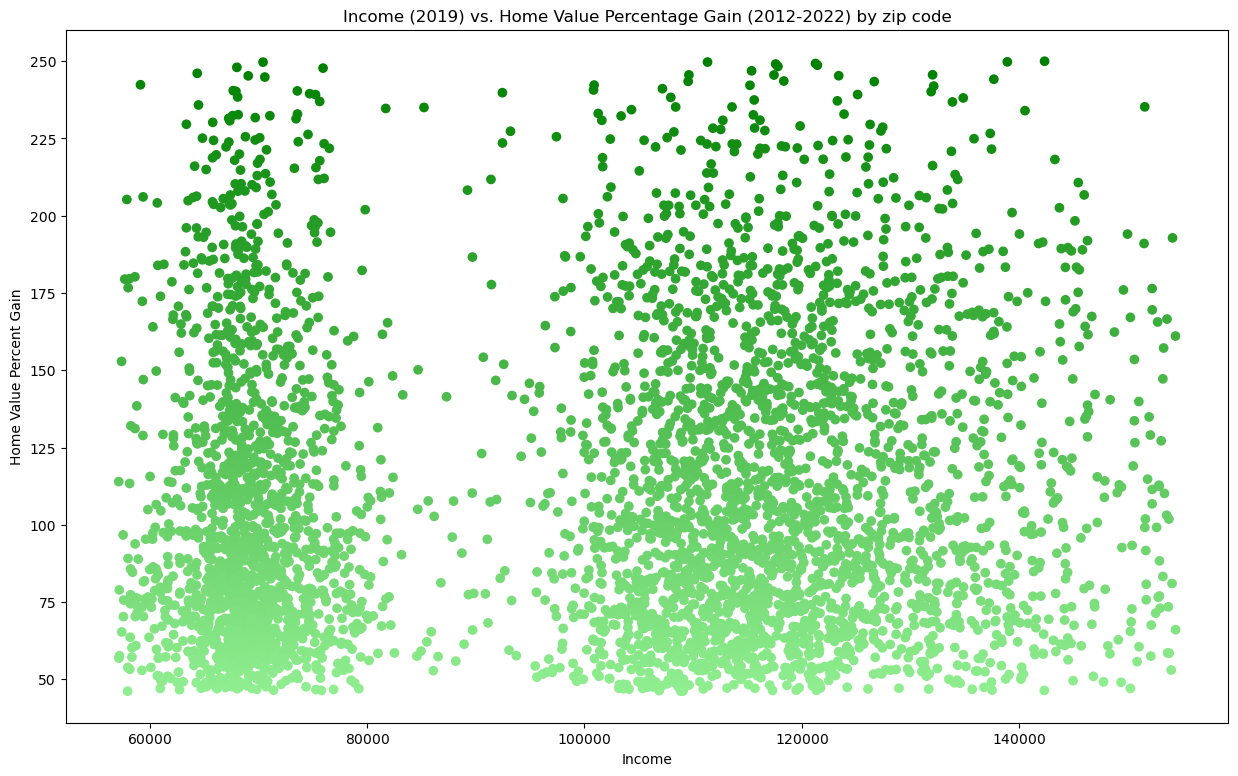

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
plt.figure(figsize=(15, 9))

colors = [(0, 'lightgreen'), (1, 'green')] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomColormap', colors)

plt.scatter(QE_IRS['Avg_AGI'], QE_IRS['Percent Gain'], c=QE_IRS['Percent Gain'], cmap=custom_cmap)

# Set the x-axis tick formatter to display the true units
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)

# Set other plot settings (labels, title, etc.)
plt.xlabel('Income')
plt.ylabel('Home Value Percent Gain')
plt.title('Income (2019) vs. Home Value Percentage Gain (2012-2022) by zip code')

# Show the plot
plt.show()

In [65]:
# Define the date range for columns you want to drop
start7 = '2022-07-31'
end7 = '2023-01-31'
# Find the indices of the columns to drop
drop_columns_indices7 = [
    idx for idx, col in enumerate(df1.columns)
    if start7 <= col <= end7
]
QT = df1.drop(df1.columns[drop_columns_indices7], axis=1)

# Drop everything after the date range
start8 = '2023-02-28'
# Find the index of the starting date column
idx7 = QT.columns.get_loc(start8)
# Drop columns from index to end
columns_to_drop7 = QT.columns[idx7 + 1:]
QT = QT.drop(columns_to_drop7, axis=1)

# Drop everything before the date range
end8 = '2022-06-30'
idx8 = QT.columns.get_loc(end8)
columns_to_drop8 = QT.columns[2:idx8]
QT = QT.drop(columns_to_drop8, axis=1)
QT = QT.dropna()
QT.head()

RegionID        CountyName     2022-06-30     2023-02-28
0     61148      Ocean County  618943.205431  658169.291012
1     91982  Fort Bend County  487199.515027  481907.580368
2     91940     Harris County  281693.328976  279778.152852
3     62080     Queens County  880043.001159  885657.420808
4     92593     Travis County  471061.546534  431536.375585

In [66]:
# Calculate percent gain and create a new 'Percent Gain' column
QT['Percent Gain'] = (QT['2023-02-28'] / QT['2022-06-30'] - 1) * 100
QT.head()

RegionID        CountyName     2022-06-30     2023-02-28  Percent Gain
0     61148      Ocean County  618943.205431  658169.291012      6.337590
1     91982  Fort Bend County  487199.515027  481907.580368     -1.086195
2     91940     Harris County  281693.328976  279778.152852     -0.679880
3     62080     Queens County  880043.001159  885657.420808      0.637971
4     92593     Travis County  471061.546534  431536.375585     -8.390660

In [68]:

QT = QT.drop(columns=['CountyName', '2022-06-30', '2023-02-28'], axis=1)
QT.columns = ['zip', 'Percent Gain']
QT = QT.set_index(['zip'])

In [69]:
QT_IRS = pd.merge(QT, irs3, on='zip', how='inner')
QT_IRS = QT_IRS.dropna()
QT_IRS.isnull().sum()
QT_IRS.head()

Percent Gain        Avg_AGI
zip                               
62080      0.637971   67501.655983
62019     -0.890347   70996.666667
91733     -0.226521  118467.408339
84630     -3.470447   65311.111111
62037     -3.573545  111061.646825

In [70]:
# Calculate the lower and upper quantile values
qtq_low = QT_IRS.quantile(0.05)
qtq_high = QT_IRS.quantile(0.95)
# Filter out the outliers
QT_IRS = QT_IRS[(QT_IRS >= qtq_low) & (QT_IRS <= qtq_high)]

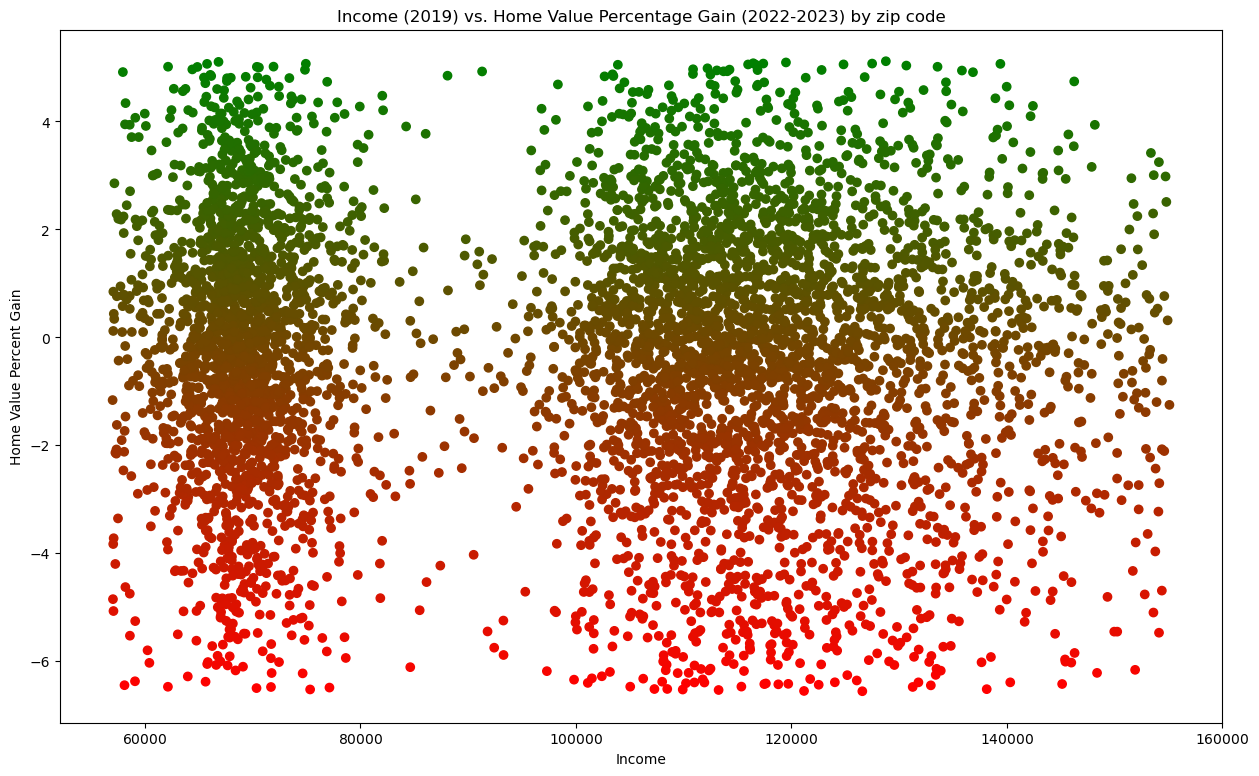

<Figure size 640x480 with 0 Axes>

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
plt.figure(figsize=(15, 9))

colors = [(0, 'red'), (1, 'green')] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomColormap', colors)

plt.scatter(QT_IRS['Avg_AGI'], QT_IRS['Percent Gain'], c=QT_IRS['Percent Gain'], cmap=custom_cmap)

# Set the x-axis tick formatter to display the true units
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)

# Set other plot settings (labels, title, etc.)
plt.xlabel('Income')
plt.ylabel('Home Value Percent Gain')
plt.title('Income (2019) vs. Home Value Percentage Gain (2022-2023) by zip code')

# Show the plot
plt.show()

In [122]:
QT_sorted = QT.sort_values(by='Percent Gain', ascending=True)
QT_sorted.head()

RegionID        CountyName     2022-06-30     2023-02-28  Percent Gain
14428     87055       Linn County  233508.586960  179338.496426    -23.198329
25181     88552  Lafourche Parish  110941.536532   86870.892342    -21.696693
20839     64101    Fayette County   39487.270639   30969.918153    -21.569869
25145     92399      Duval County   93262.646916   75246.200413    -19.317966
19396     98471      Butte County  310190.157589  251096.730775    -19.050710

In [123]:
QT.to_csv('tableau_QT.csv', index=False)